In [103]:
import numpy as np
from numpy import sin, sqrt, abs
from numpy.random import randint, rand, choice
from itertools import product

%matplotlib inline
import matplotlib.pyplot as plt


rng = np.random.default_rng()

In [2]:
def rastrigin(x):
    # -5.12 <= x_i <= 5.12 for i=1,..,n
    # global minimum at f(0,..,0)=0
    if isinstance(x, list):
        x = np.array(x)
    A, n = 10, len(x)
    return A * n + np.sum(x ** 2 - A * np.cos(2 * np.pi * x), axis=0)


def booth(arg):
    # -10 <= x,y <= 10 
    # global minimum at f(1,3)=0
    x, y = arg
    return (x + 2 * y - 7) ** 2 + (2 * x + y - 5) ** 2


def eggholder(arg):
    # -512 <= x,y <= 512
    # global minimum at f(512,404.2319)=-959.6407
    x, y = arg
    return -(y + 47) * sin(sqrt(abs(x / 2 + y + 47))) - x * sin(sqrt(abs(x-y-47)))


functions_data = {
    'rastrigin': {
        'func': rastrigin, 
        'bounds': [[-5.12, 5.12], [-5.12, 5.12]], 
        "best": ([0.0, 0.0], 0.0)
    },
    'booth'    : {
        'func': booth,     
        'bounds': [[-10, 10], [-10, 10]], 
        "best": ([1, 3], 0.0)
    },
    'eggholder': {
        'func': eggholder, 
        'bounds': [[-512.0, 512.0], [-512.0, 512.0]], 
        "best": ([512, 404.2319], -959.6407)
    },
}

In [250]:
def generate_points(obj_func, bounds, k):
    points = np.random.uniform(size=(k, len(bounds)))
    scalers = [right - left for left, right in bounds], [left for left, right in bounds]
    scaled_points = points * scalers[0] + scalers[1]
    sorted_points = sorted(scaled_points, key=obj_func)  # sort points in acsending order 
    return np.array(sorted_points)

# Method of Deformed Stars 

### (triangular case for 2 dimensuions)

<img src="images/mods1.png" width=500 height=500 />
<img src="images/mods2.png" width=500 height=500 />

Stopping condition
<img src="images/mods3.png" width=500 height=500 />

In [12]:
def should_stop(pop, func, i, max_iter, eps, delta):
    pairs = product()
    if (
        i >= max_iter or 
        max([np.linalg.norm(x - y) for x, y in product(func, func)]) < eps or
        max([np.linalg.norm(a - b) for a, b in product(pop, pop)]) < delta
    ):
        return True
    return False

# should_stop(np.array([[1, 2], [1, 1], [4, 5]]), [0.5, 1, 9], 0, 5, 1, 1)

False

In [160]:
def select_best(pop, func, k):
    F = func(pop.T)
    lst = sorted(zip(pop, F), key=lambda x: x[1])
    sorted_lst = list(zip(*lst))
    best_pop = sorted_lst[0][:k]
    best_F = sorted_lst[1][:k]
    return np.array(best_pop), list(best_F)


In [126]:
def generate_triangles(pop, n):
    return [rng.choice(pop, 3, replace=False) for _ in range(n)] 


In [233]:
def put_into_rectangle(triangle, bounds):
    (lx, rx), (ly, ry) = bounds
    corrected_triangle = []
    for x, y in triangle:
        if x > rx:
            x = lx + x - rx
        elif x < lx:
            x = rx + x - lx
        if y > ry:
            y = ly + y - ry
        elif y < ly:
            y = ry + y - ly
        corrected_triangle.append([x, y])
    return corrected_triangle


In [102]:
def get_best(triangle, obj_func):
    sorted_p = sorted(triangle, key=obj_func)
    return sorted_p[0], sorted_p[1:]


def get_center(triangle):
    return [sum(triangle[:,0]) / 3, sum(triangle[:, 1]) / 3]


In [ ]:
def get_center(p):
    return [sum(p[:,0]) / 3, sum(p[:, 1]) / 3]

In [278]:
def shift(center, best, other):
    x0, y0 = center
    a = rand()
    shifted_best = [((1 + a) * best[0] - a * x0, (1 + a) * best[1] - a * y0)]
    shifted_other = [
        [(best[0] + a * x) / (1 + a), (best[1] + a * y) / (1 + a)]
        for x, y in other
    ]
    return shifted_best + shifted_other

In [212]:
def rotate_around_best(best, other):
    alpha = rand() * 2 * np.pi
    sin, cos = np.sin(alpha), np.cos(alpha)
    x0, y0 = best
    return [best] + [
            (x0 + (x - x0) * cos - (y - y0) * sin, y0 + (x - x0) * sin + (y - y0) * cos)
            for x, y in other
        ]


In [214]:
def rotate_around_center(triangle):
    alpha = rand() * 360
    sin, cos = np.sin(alpha), np.cos(alpha)
    x0, y0 = get_center(triangle)
    return [
        [(x - x0) * cos - (y - y0) * sin + x0, (x - x0) * sin + (y - y0) * cos + y0]
        for x, y in triangle
    ]

In [251]:
def array2set(array):
    return set([tuple(el) for el in array])

In [299]:
def MODS3(func_name="booth", k=20, n=15, max_iter=100, eps=0.1, delta=0.1):
    func, bounds = functions_data[func_name]["func"], functions_data[func_name]["bounds"]
    i = 0
    P = generate_points(func, bounds, k)
    F = func(P.T)
    results = {}
    while not should_stop(P, F, i, max_iter, eps, delta):
        P_new = array2set(P)
        Pz, Ps, Pw = set(), set(), set()
        triangles = generate_triangles(P, n)

        for triangle in triangles:
            best, center = get_best(triangle, func), get_center(triangle)
            shifted = put_into_rectangle(shift(center, *best), bounds)
            rotated1 = put_into_rectangle(rotate_around_best(*best), bounds)
            rotated2 = put_into_rectangle(rotate_around_center(triangle), bounds)
            P_new = P_new.union(array2set(shifted), array2set(rotated1), array2set(rotated2))
#             Pz = Pz.union(array2set(shifted))
#             Ps = Ps.union(array2set(rotated1))
#             Pw = Pw.union(array2set(rotated2))
#         P_new = np.array(list(P_new.union(Pz, Pw, Ps)))
        i += 1
        P, F = select_best(np.array(list(P_new)), func, k)
        results[i] = [P[0], F[0]]
        
    return i, results


# Testing

In [346]:
def present_results(f_name, i, results):
    print(
        f"result: f({results[i][0][0]: .5f}, {results[i][0][1]: .5f}) = {results[i][1]: .5f} "
        f"(stopped after {i} iterations)"
    )

    scores = [res[1] for res in results.values()]
    plt.plot(results.keys(), scores, marker=5)
    plt.xlabel("# Iterations")
    plt.ylabel("Optimum")
    plt.title(f_name)
    plt.show()

result: f( 0.00142, -0.00034) =  0.00042 (stopped after 15 iterations)


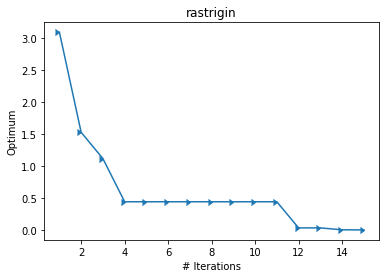

In [347]:
i, results = MODS3(func_name="rastrigin", k=20, n=15, eps=0.01, delta=0.01)
present_results("rastrigin", i, results)

result: f( 1.00152,  2.99771) =  0.00001 (stopped after 5 iterations)


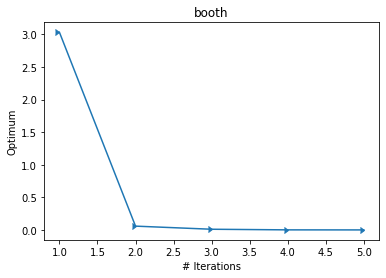

In [348]:
i, results = MODS3(func_name="booth", k=20, n=15, eps=0.01, delta=0.01)
present_results("booth", i, results)

result: f( 482.34465,  432.86630) = -956.91781 (stopped after 14 iterations)


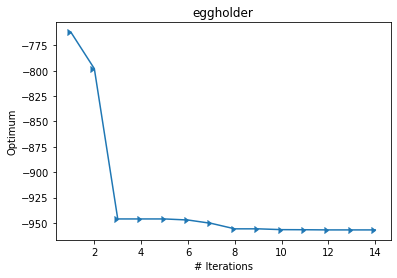

In [351]:
i, results = MODS3(func_name="eggholder", k=20, n=30, eps=0.01, delta=0.01)
present_results("eggholder", i, results)